# Basis function construction



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import datetime

Load monitor data

In [2]:
monitor_df = pd.read_csv("./data/monitors_rnd.csv")
monitor_df.head()

,id,lat,lon,date,pm25
0,49-035-2005,40.597911,-111.894162,2020-06-01T00:00:00Z,-3.423297
1,49-035-2005,40.597911,-111.894162,2020-06-01T01:00:00Z,-2.813480
2,49-035-2005,40.597911,-111.894162,2020-06-01T02:00:00Z,0.826602
3,49-035-2005,40.597911,-111.894162,2020-06-01T03:00:00Z,3.774218
4,49-035-2005,40.597911,-111.894162,2020-06-01T04:00:00Z,5.990525


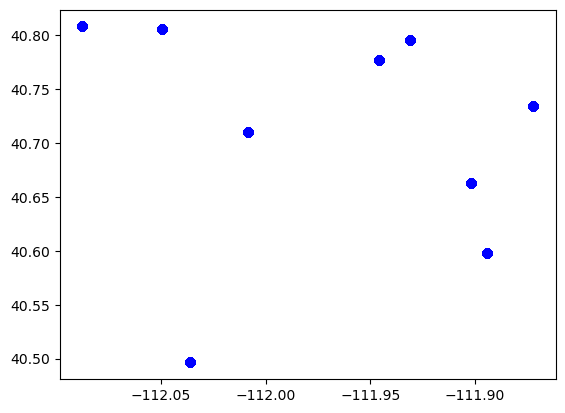

In [3]:
plt.plot(monitor_df['lon'], monitor_df['lat'], 'bo')

Load grid (we'll need to filter this down)

In [4]:
grid_gdf = geopandas.read_file("./data/coarse_grid_pts/grid_pts_coarse.shp")

<Axes: >

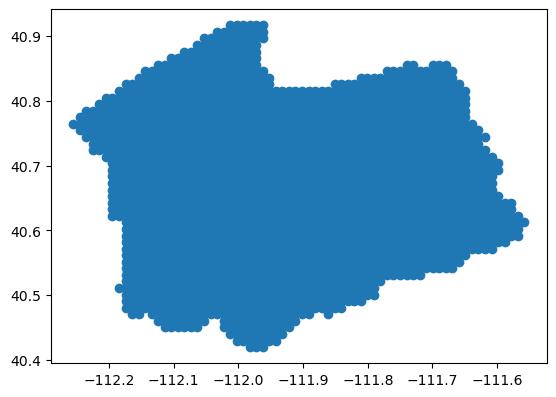

In [5]:
grid_gdf.plot()

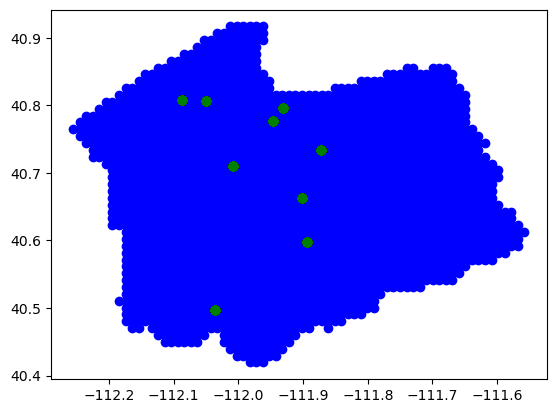

In [6]:
grid_crds = grid_gdf.get_coordinates()
plt.plot(grid_crds['x'], grid_crds['y'], 'bo')
plt.plot(monitor_df['lon'], monitor_df['lat'], 'go')

In [7]:
ebus = pd.read_csv("./data/EBUS_TEST_DATA/BUS04_2023_06.csv", header = [0,1],  
                 na_values = -9999.00)


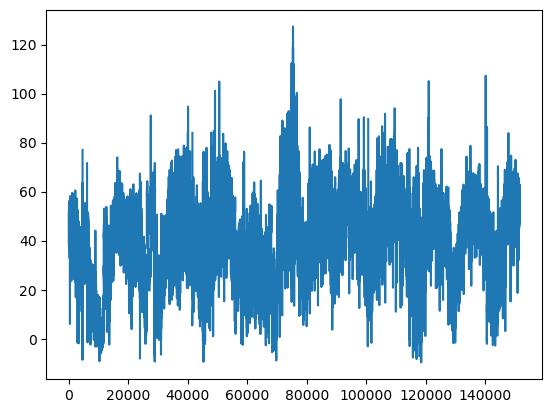

In [8]:
plt.plot(ebus['2B_Ozone_Concentration'])

## Get limits and standarize



### Coordinates

In [9]:
min_x = grid_crds.x.min()
max_x = grid_crds.x.max()
min_y = grid_crds.y.min()
max_y = grid_crds.y.max()
print(min_x, max_x, min_y, max_y)


-112.25516635714284 -111.55831564285714 40.419293290000006 40.916769710000004


In [10]:
lon = monitor_df.values[:,1]
lat = monitor_df.values[:,2]
normalized_lon = (lon-min_x)/(max_x - min_x)
normalized_lat = (lat-min_y)/(max_y-min_y)
N = lon.shape[0]
print(N)

256401


### Time

In [15]:
date = monitor_df['date']
date = pd.to_datetime(date)
# add the timezone:

print(date[0:10])
print(date.dtype)

0   2020-06-01 00:00:00+00:00
1   2020-06-01 01:00:00+00:00
2   2020-06-01 02:00:00+00:00
3   2020-06-01 03:00:00+00:00
4   2020-06-01 04:00:00+00:00
5   2020-06-01 05:00:00+00:00
6   2020-06-01 06:00:00+00:00
7   2020-06-01 07:00:00+00:00
8   2020-06-01 08:00:00+00:00
9   2020-06-01 09:00:00+00:00
Name: date, dtype: datetime64[ns, UTC]
datetime64[ns, UTC]


In [16]:
date = date.astype('int64') / 1e9 ## Time in nanoseconds

In [18]:
min_t = date.min()
max_t = date.max()
print(min_t, max_t)

1590969600.0 1693526400.0


In [20]:
monitor_df['date2'] = (date - min_t) / (max_t-min_t)
monitor_df['date2']

0         0.000000
1         0.000035
2         0.000070
3         0.000105
4         0.000140
            ...   
256396    0.999860
256397    0.999895
256398    0.999930
256399    0.999965
256400    1.000000
Name: date2, Length: 256401, dtype: float64

## Basis functions

### Time

In [21]:
s = np.array(monitor_df['date2']).reshape(len(monitor_df),1)
print(s.shape)
N_data = len(monitor_df)
N = N_data ## We have a separate N for the training + test data set (no testing at present)
print(N)

(256401, 1)


We need to define:
- Number of basis layers (3)
- Number of knots per layer
- S.D. for Gaussian function

Then make a ragged array holding the knots on the normalized scale.

Note that one of the previous examples has a very high number of temporal knots (~800) which is very computationally expensive

In [23]:
## time basis 
num_basis = [10,15,45]
std_arr = [0.4,0.2,0.1]
#num_basis = [70,250,410]
#std_arr = [0.2,0.09,0.009]
#std_arr = [0.3,0.15,0.05]

mu_knots = [np.linspace(0,1,int(i)) for i in num_basis]

In [24]:
mu_knots

[array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
        0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
        0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ]),
 array([0.        , 0.02272727, 0.04545455, 0.06818182, 0.09090909,
        0.11363636, 0.13636364, 0.15909091, 0.18181818, 0.20454545,
        0.22727273, 0.25      , 0.27272727, 0.29545455, 0.31818182,
        0.34090909, 0.36363636, 0.38636364, 0.40909091, 0.43181818,
        0.45454545, 0.47727273, 0.5       , 0.52272727, 0.54545455,
        0.56818182, 0.59090909, 0.61363636, 0.63636364, 0.65909091,
        0.68181818, 0.70454545, 0.72727273, 0.75      , 0.77272727,
        0.79545455, 0.81818182, 0.84090909, 0.86363636, 0.88636364,
        0.90909091, 0.93181818, 0.95454545, 0.97727273, 1.        ])]

Now create the basis functions. This does the following:
- Loop over each basis layer
- Loop by knot in the selected layer
- Get distance from each observation (held in `s`) to the knot
- Estimate Gaussian weight

In [25]:
phi_t = np.zeros((N, sum(num_basis)))
K = 0
for res in range(len(num_basis)):
    std = std_arr[res]
    for i in range(num_basis[res]):
        d = np.square(np.absolute(s-mu_knots[res][i]))
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi_t[j,i + K] = np.exp(-0.5 * d[j]/(std**2))
            else:
                phi_t[j,i + K] = 0
    K = K + num_basis[res]

/var/folders/ws/m03sh3xd4ns621mckfrht3r0000_08/T/ipykernel_34055/420065419.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi_t[j,i + K] = np.exp(-0.5 * d[j]/(std**2))


Plot basis functions at location (time) 0

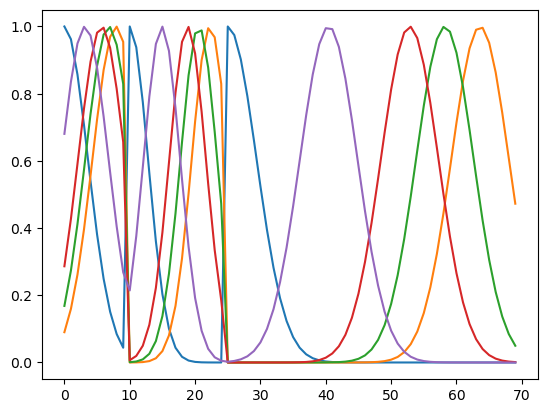

In [35]:
plt.plot(phi_t[0,:])
plt.plot(phi_t[25000,:])
plt.plot(phi_t[50000,:])
plt.plot(phi_t[75000,:])
plt.plot(phi_t[10000,:])
plt.show()

Plot first basis function (over all time)

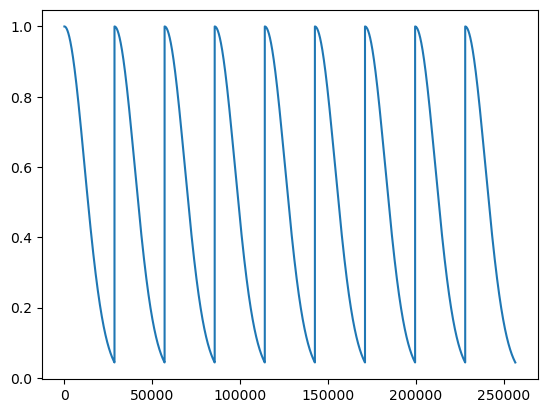

In [36]:
plt.plot(phi_t[:,0])